In [ ]:
# code by Zhengcaizhi

### 实验差值数据集敏感程度

In [1]:
import numpy as np 
import tensorflow as tf 
import skrf as rf

In [2]:
origin_paras = np.genfromtxt('D:/data/Data_ov2/MP50.csv',delimiter=',')

In [3]:
a0  = origin_paras[0]
a3  = origin_paras[1000]


In [39]:
a3[0] = a3[0] + 0.02
a3

array([ 1.71210242e-01,  1.27735547e-01,  5.30458092e+01,  1.05605121e-01,
        4.07146429e+03,  3.04060812e-04,  2.87057411e-02,  1.38237648e+02,
        3.82456491e-01, -8.39367874e-02,  7.12942589e+01,  1.15233047e-01,
        7.05841168e-01,  8.45349070e+03,  7.12842569e-01,  5.47649530e-01])

In [4]:
saw_set = rf.read_all_networks('./SNP Selection/LT60MP50P20/')
for name in saw_set:
    saw = saw_set[name]
Y0 = saw['750MHZ-1250MHZ'].y[:,0,0]

In [5]:
from data_gene_new import cacul
NT = 60
Pitch = 200
freq = np.linspace(7.5*1e8,12.5*1e8,2001)
Y_DL0 = cacul(a0, freq, NT, Pitch*1e-8)
Y_DL3 = cacul(a3, freq, NT, Pitch*1e-8)

In [47]:
Y_DL0-Y_DL3

array([-0.00019462+0.00195177j, -0.00019224+0.00195303j,
       -0.00018982+0.00195406j, ..., -0.00019587+0.00358645j,
       -0.00019571+0.00358814j, -0.00019554+0.00358982j])

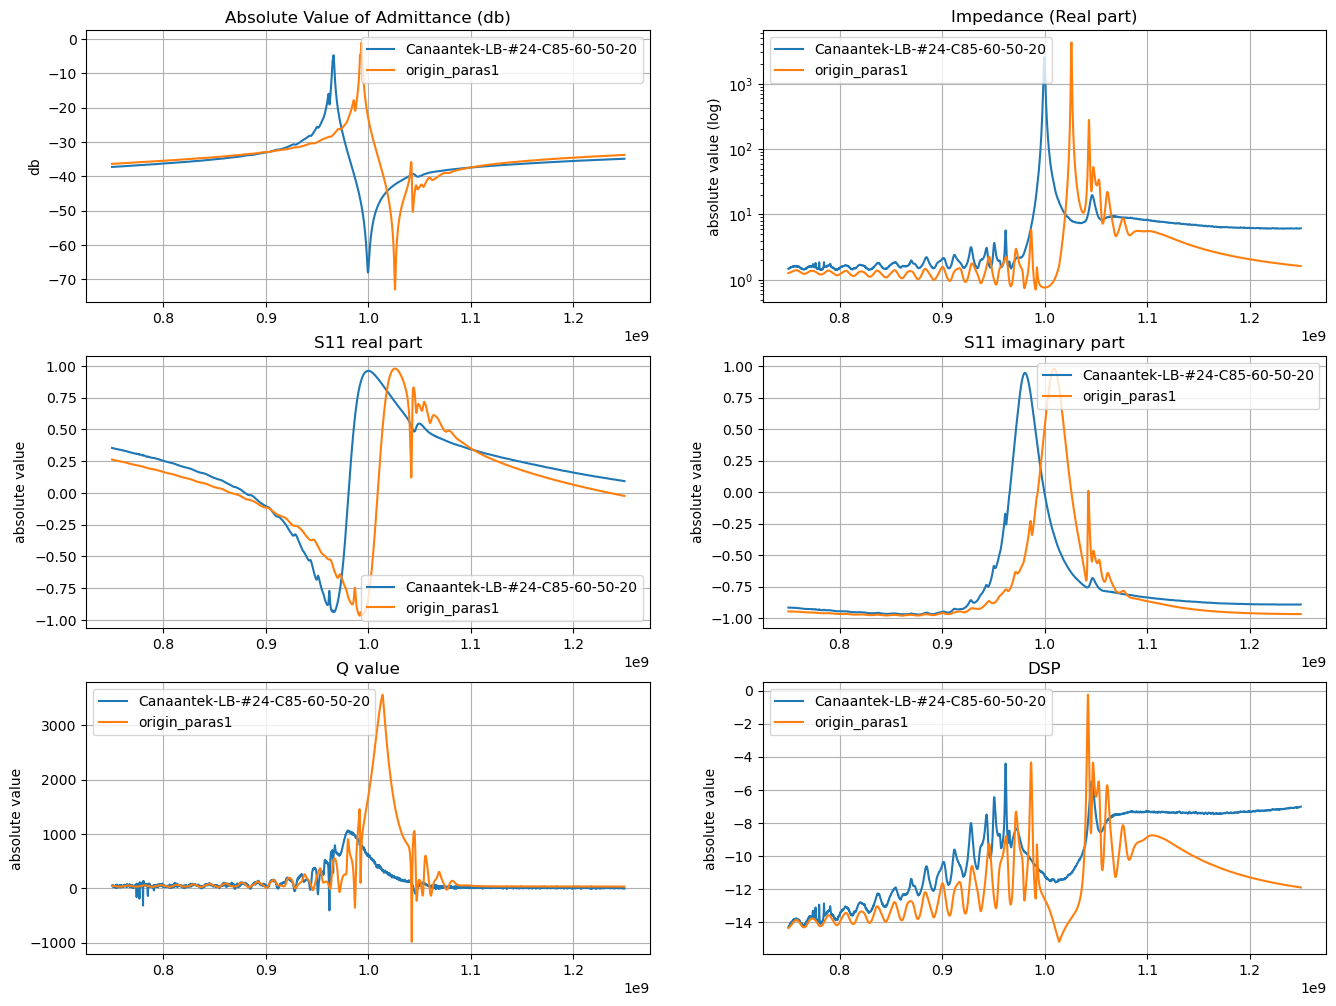

In [6]:
from PackClass import Plot_all
pp = Plot_all(Y0, Y_DL0, freq, name1 = saw.name,name2= 'origin_paras1', choice=False)
# pp.plot_all()  
# pp3 = Plot_all(Y0, Y_DL3, freq, name = saw.name, choice=False)
# pp3.plot_all()
# ppp = Plot_all(Y_DL0, Y_DL3, freq, name = 'origin_paras0', choice=False)
pp.plot_all()
# ppp1 = Plot_all(Y_DL3, Y_DL0, freq, name = 'origin_paras0', choice=False)
# ppp.plot_all()


In [7]:
yzsqd0=[Y0_Y11, Y0_Z, Y0_SR, Y0_SI, Y0_Q, Y0_D] = pp.YtoZS(Y0, freq)
yzsqd_dl0=[YDL0_Y11, YDL0_Z, YDL0_SR, YDL0_SI, YDL0_Q, YDL0_D] = pp.YtoZS(Y_DL0, freq)
yzsqd_dl3=[YDL3_Y11, YDL3_Z, YDL3_SR, YDL3_SI, YDL3_Q, YDL3_D] = pp.YtoZS(Y_DL3, freq)

In [9]:
dd0 = tuple(map(lambda i,j: yzsqd0[i]- yzsqd_dl0[i], range(len(yzsqd_dl0)), range(len(yzsqd0))))
dd1 = tuple(map(lambda i,j: yzsqd0[i]- yzsqd_dl3[i], range(len(yzsqd_dl3)), range(len(yzsqd0))))
dd2 = tuple(map(lambda i,j: yzsqd0[i]- yzsqd0[i], range(len(yzsqd0)), range(len(yzsqd0))))

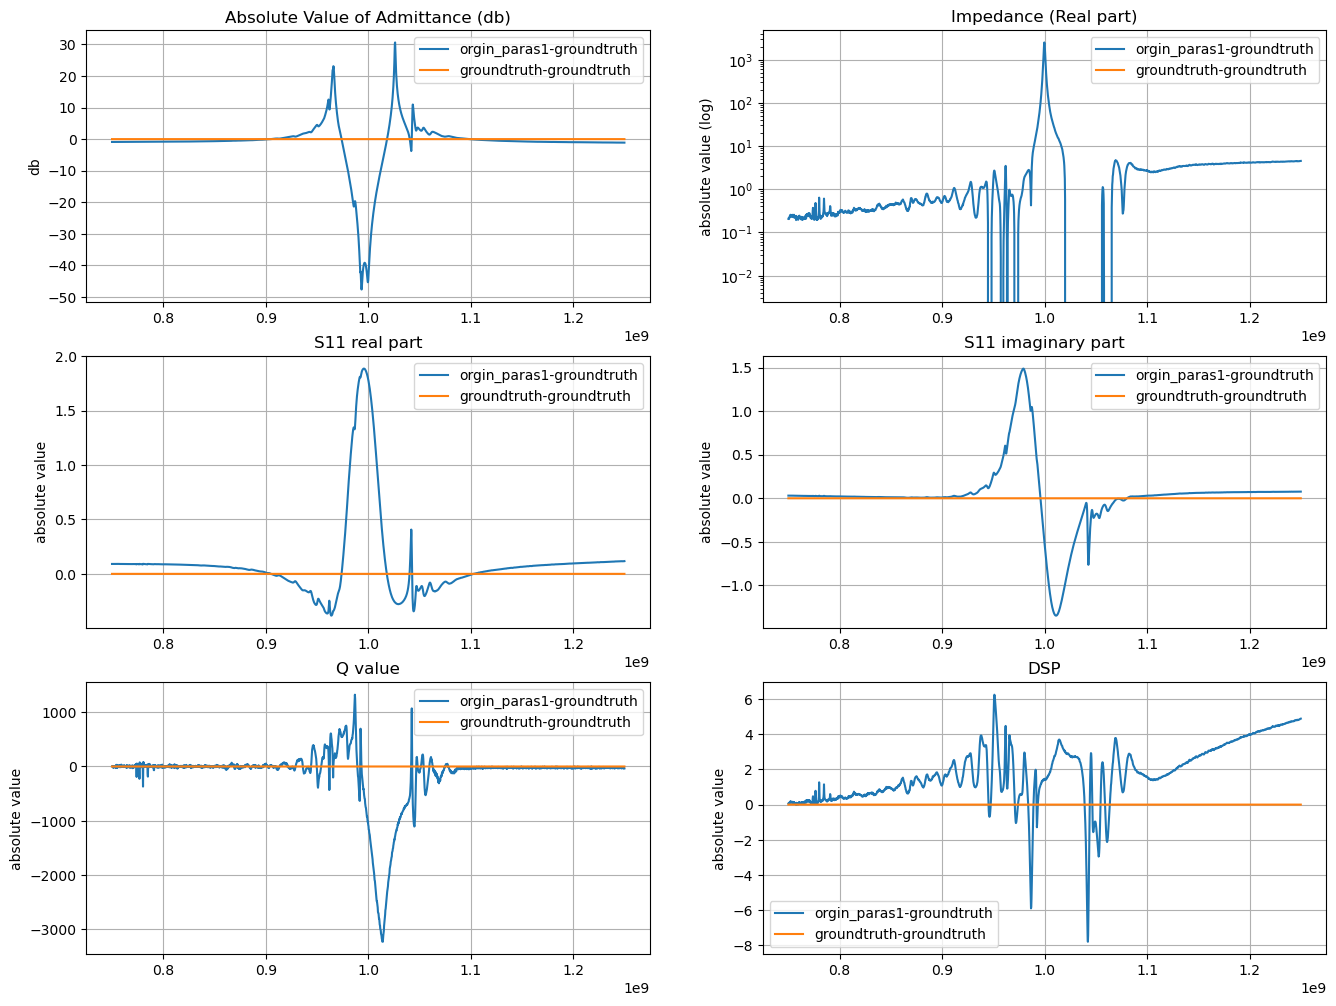

In [11]:
# dif0 = Plot_all(Y0,Y_DL0,freq,name=saw.name, choice=True, yzsqd1=yzsqd0, yzsqd2=dd0)
# dif0.plot_all()
# dif1 = Plot_all(Y0,Y_DL3,freq,name=saw.name, choice=True, yzsqd1=yzsqd0, yzsqd2=dd1)
# dif1.plot_all()
dif2 = Plot_all(Y_DL0,Y_DL0,freq=freq,name1='orgin_paras1-groundtruth',name2='groundtruth-groundtruth', choice=True, yzsqd1=dd0,yzsqd2=dd2)
dif2.plot_all()

In [13]:
dd2 = np.array(dd2)
dd2 = np.transpose(dd2)
mu = np.mean(dd2, axis=0)
sigma = dd2.std(axis=0)
if (sigma == 0).all() == False:
    dd2_zs = (dd2 - mu)/sigma
else: dd2_zs = dd2 - mu
dd2 = np.transpose(dd2)
dd2_zs = np.transpose(dd2_zs)

In [35]:
dd0_zs[1]

array([-0.01592244, -0.01587895, -0.015883  , ...,  0.00567587,
        0.00567691,  0.00574877])

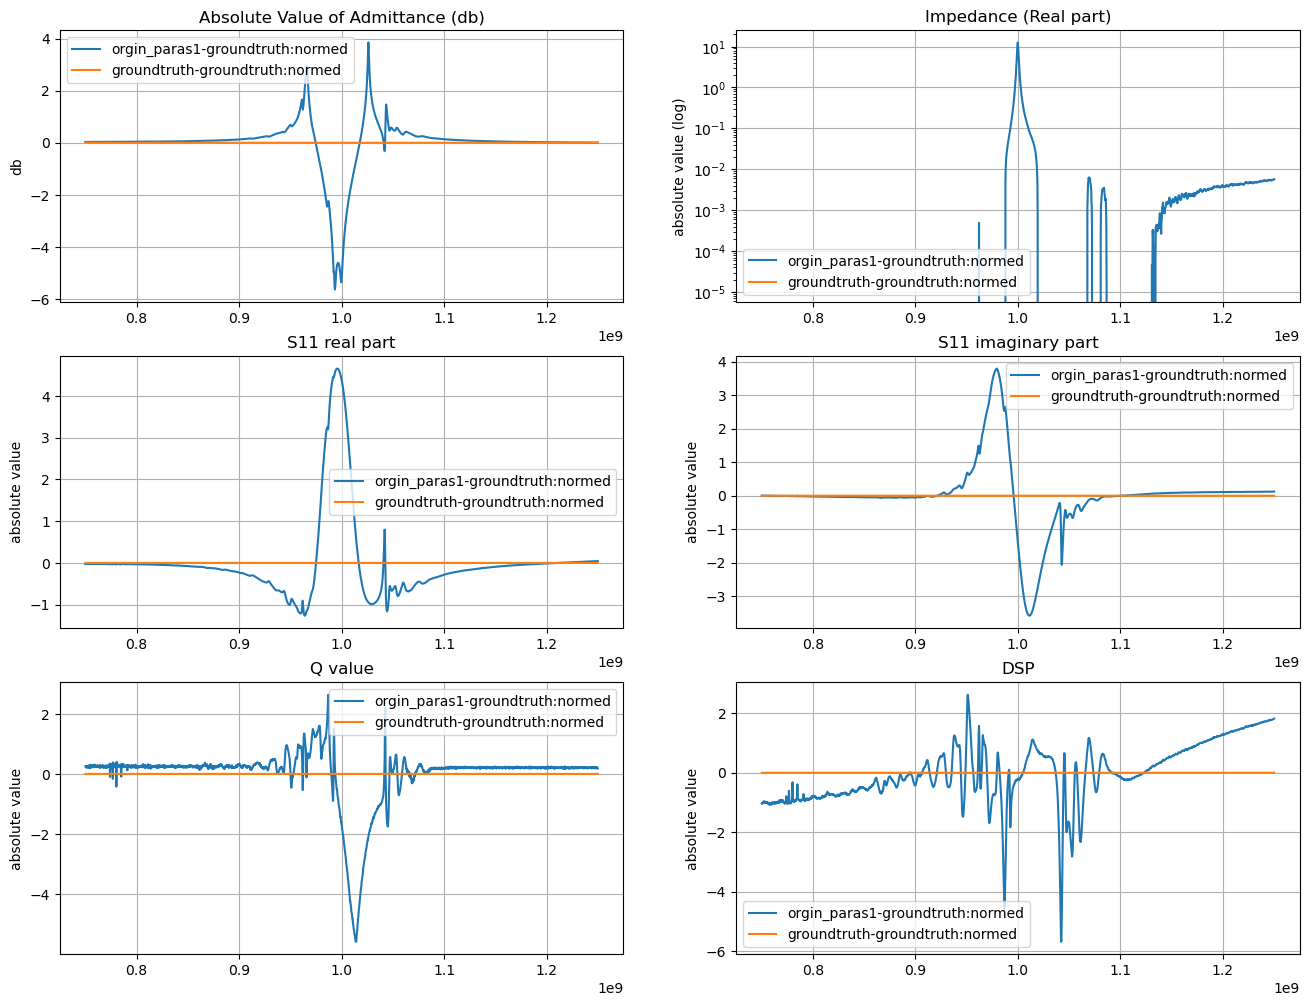

In [15]:
dif2 = Plot_all(Y_DL0,Y_DL3,freq,name1='orgin_paras1-groundtruth:normed',name2='groundtruth-groundtruth:normed', choice=True, yzsqd1=dd0_zs, yzsqd2=dd2_zs)
dif2.plot_all()

In [5]:
zeros = np.zeros((2001,6))
mu = np.mean(zeros, axis=0)
sigma = zeros.std(axis=0)
(zeros - mu)/sigma
np.std()

In [127]:
def sigmoid(x):
    return 1/ (1+np.exp(-x))
for i in range(6):
    dd0_zs[i] = sigmoid(dd0[i])
    dd1_zs[i] = sigmoid(dd1[i])

C:\Users\caizhi.zheng\AppData\Local\Temp\ipykernel_11744\3529570330.py:2: RuntimeWarning: overflow encountered in exp
  return 1/ (1+np.exp(-x))


In [ ]:
from sklearn.preprocessing import QuantileTransformer, PowerTransformer
PT = PowerTransformer('box-cox') 
for i in range(6):
    dd0_zs[i] = PT.fit(dd0[i])

### 暂时用z-score if排除全0

In [54]:
# %load data_gene_new
import skrf as rf
import numpy as np
from PackClass import Plot_all
# 根据16个参数计算Y11值
def cacul(x, freq,NT,Pitch):
    
    Refl0 = x[0]
    Alpha0 = x[1]
    ReEps = x[2]
    dT = x[3]
    SAW_Vel = x[4]
    Ksi0 = x[5]
    Ksi1 = x[6]
    Ksi2 = x[7]
    Ksi3 = x[8]
    Delta_Ksi = x[9]
    Delta_Fr_Ksi = x[10]
    Cp = x[11]
    Rs = x[12]
    Rp = x[13]
    Ls = x[14]

    M = x[15]
    # M = 0.5
    # NT = 60
    NR = 20
    # Pitch = 2.6*1e-6
    W = 40*Pitch
    ii = 1j
    Eps0 = ReEps
    Freq0=SAW_Vel/(2*Pitch)
    Refl=Refl0*freq/Freq0
    Eps=Eps0*np.exp(0.71866*np.tan(1.966*(M-0.5)))
    C0=(1+Eps)*8.851*pow(10,-12)*NT*W
    Alpha=Alpha0*(1-2*(M-0.5)**2)*np.sqrt(freq/Freq0)*np.exp(0.35933*np.tan(1.966*(M-0.5)))
    Attn1=np.exp(-Ksi2*(freq-Freq0-Delta_Fr_Ksi*10**6)/Freq0)+Ksi3
    Attn=np.maximum(Ksi0+Delta_Ksi*(Freq0-freq)/Freq0+Ksi1/Attn1,0)
    AttnR=Attn
    AttnG=Attn
    Fr_C0=2*np.pi*freq*C0
    PM_alpha=np.sqrt(0.5*Alpha*NT*Fr_C0)
    PM_a=2*np.pi*NT*freq/(Freq0-dT*(freq-Freq0))-2*np.pi*NT-ii*Attn*NT
    PM_b=Refl*NT
    PM_z=np.sqrt(PM_a*PM_a-PM_b*PM_b)
    Denom=PM_z*np.cos(PM_z)+ii*PM_a*np.sin(PM_z)
    P11_T=-ii*PM_b*np.sin(PM_z)/Denom
    P12_T=PM_z/Denom
    P13_T=ii*PM_alpha*(PM_z*np.sin(PM_z)+ii*(PM_a-PM_b)*(1-np.cos(PM_z)))/(PM_z*Denom)
    P33_X=(PM_z*np.sin(PM_z)+ii*(PM_a-PM_b)*(1-np.cos(PM_z)))/(PM_z*Denom)-1
    P33_T=ii*Fr_C0*(1+Cp)+4*ii*PM_alpha**2/(PM_a+PM_b)*P33_X
    PM_aR=2*np.pi*NR*freq/(Freq0-dT*(freq-Freq0))-2*np.pi*NR-ii*AttnR*NR
    PM_bR=Refl*NR
    PM_zR=np.sqrt(PM_aR*PM_aR-PM_bR*PM_bR)
    DenomR=PM_zR*np.cos(PM_zR)+ii*PM_aR*np.sin(PM_zR)
    P11_R=-ii*PM_bR*np.sin(PM_zR)/DenomR
    PM_aG=np.pi*freq/(Freq0-dT*(freq-Freq0))-np.pi-ii*AttnG*0.5
    PM_bG=Refl*0.5
    PM_zG=np.sqrt(PM_aG*PM_aG-PM_bG*PM_bG)
    DenomG=PM_zG*np.cos(PM_zG)+ii*PM_aG*np.sin(PM_zG)
    P11_G=-ii*PM_bG*np.sin(PM_zG)/DenomG
    P12_G=-PM_zG/DenomG
    # Y_ResAcModel=P33_T-4*P11_R*P13_T*P13_T/(1-P11_R*(P11_T+P12_T))
    Mult=P11_G+P11_R*P12_G*P12_G/(1-P11_G*P11_R)
    Y5_ResAcModel=P33_T-4*Mult*P13_T*P13_T/(1-Mult*(P11_T+P12_T))
    Y_COM=(Y5_ResAcModel+1/Rp)/(1+(Y5_ResAcModel+1/Rp)*(Rs+2*ii*np.pi*freq*10**(-9)*Ls))
    # y = 20*np.log10(abs(Y_COM))
    # y = np.stack((freq,y), axis=-1)
    return Y_COM

if __name__ == '__main__':
    # names = np.genfromtxt('C:\\Users\\caizhi.zheng\\code\\For AI\\MB COM/name.csv', delimiter=',')
    MP_num = [45,50,55,60,65]
    # MP_num = [65]
    Pitch_num = [180,200,225,260]
    freq_star = [8.5, 7.5, 6.5, 5.5]
    # PF = [[180,8.5],[200,7.5],[225,6.5],[260,5.5]]
    PF = [[200,7.5]]
    # names = [[150,45,80],[150,50,80],[150,55,80]
    #      ,[60,45,80],[60,50,80],[60,55,80]
    #      ,[90,45,80],[90,50,80],[90,55,80]]
    # freq = np.linspace(0.7E9, 0.9E9, 801)
    # freq = np.linspace(2.2e9,2.7e9,2001)
    # freq = np.linspace(0.5E9, 3E9, 10001)
    # for j in range(3):
    for mp in MP_num:
        for pf in PF:
            NT = 60
            # Pitch = int(names[j][2])*1e-8
            Pitch = pf[0]*1e-8
            fre_0 = pf[1]
            # freq = np.linspace(fre_0*1e8,(fre_0+5)*1e8,2001)
            freq = np.linspace(9*1e8,1.1*1e9,801)
            if pf[0] != 225:
                pitch = int(0.1*pf[0])
                test_path = 'C:\\Users\\caizhi.zheng\\code\\For AI\\SNP Selection/'+'LT'+str(NT)+ 'MP'+str(mp) +'P'+str(pitch) +'/'
            saw_set = rf.read_all_networks(test_path)
            for name in saw_set:
                saw = saw_set[name]
            # fre_str = str(fre_0*100) + '-' + str((fre_0+5)*100) +'MHZ'
            Y0 = saw['900-1100MHZ'].y[:,0,0]
            pp = Plot_all(Y0, Y0, freq, name = saw.name, choice=False)
            [Y0_Y11, Y0_Z, Y0_SR, Y0_SI, Y0_Q, Y0_D] = pp.YtoZS(Y0, freq)
            GT = np.stack((Y0_Y11, Y0_Z, Y0_SR, Y0_SI, Y0_D), axis=-1)
                
            result = []
            # freq = np.linspace(1.5E9, 2.5E9, 4001)
            # origin_sample是原本的5000组参数
            origin_paras = np.genfromtxt('D:/data/Data_ov2/MP' + str(int(mp))+ '.csv',delimiter=',')
            print('LT60-'+str(mp)+'-'+str(pf[0]))
            for i in range(0,len(origin_paras)):
                Y_COM = cacul(origin_paras[i], freq, NT=NT, Pitch=Pitch)
                Y11 = 20*np.log10(abs(Y_COM))
                # Y_com_fre = np.stack((Y11, freq), axis = -1)
                # Y11_mag = sample(Y_com_fre)
                Z_COM = 1/Y_COM
                Z11 = 20*np.log10(abs(Z_COM.real))
                # Z_com_fre = np.stack((Z_COM.real, freq), axis=-1)
                # Z11_real = sample(Z_com_fre)
                z = 50 
                S11_COM = (1-Y_COM*z)/(1+Y_COM*z)
                DSP_COM = 10*np.log10(1-abs(S11_COM)**2)
                # S_real_fre = np.stack((S11_COM.real, freq), axis=-1)
                # S11_real = sample(S_real_fre)
                # S_imag_fre = np.stack((S11_COM.imag, freq), axis=-1)
                # S11_imag = sample(S_imag_fre)
                # [Y11, Z_COM, SR, SI, Q, DSP_COM] = pp.YtoZS(Y_COM, freq)
                Inputs = np.stack((Y11, Z_COM.real, S11_COM.real, S11_COM.imag, DSP_COM), axis=-1)
                dff = Inputs-GT
                result.append(dff) 
            result = np.array(result)
            mu = result.reshape(-1,5).mean(axis = 0)
            sigma = result.reshape(-1,5).std(axis = 0)
            if (sigma == 0).all() != True:
                result = (result - mu )/ sigma
            else:
                result = result - mu
            # imi = result.reshape(-1,5).min(axis = 0)
            # ima = result.reshape(-1,5).max(axis = 0)
            # result = (result - imi )/ (ima - imi )
            # suffix = str(int(NT)) + '-' + str(int(names[j][1])) + '-' + str(int(names[j][2])) 
            suffix = str(int(NT)) + '-' + str(int(mp)) + '-' + str(int(pf[0])) 
            # 将生成的(5000,2001,4)四维矩阵直接保存为numpy格式
            # (20000,801,5)
            file_path = 'D:\\data\\Data_ov4\\input2w/' + suffix + '.npy'
            with open(file_path,'wb') as f:
                np.save(f, result)
            file_path1 = file_path + 'musi.csv'
            with open(file_path1,'w') as f:
                np.savetxt(f,mu)   
                np.savetxt(f,sigma)


LT60-45-200
LT60-50-200
LT60-55-200
LT60-60-200
LT60-65-200


### 四参数

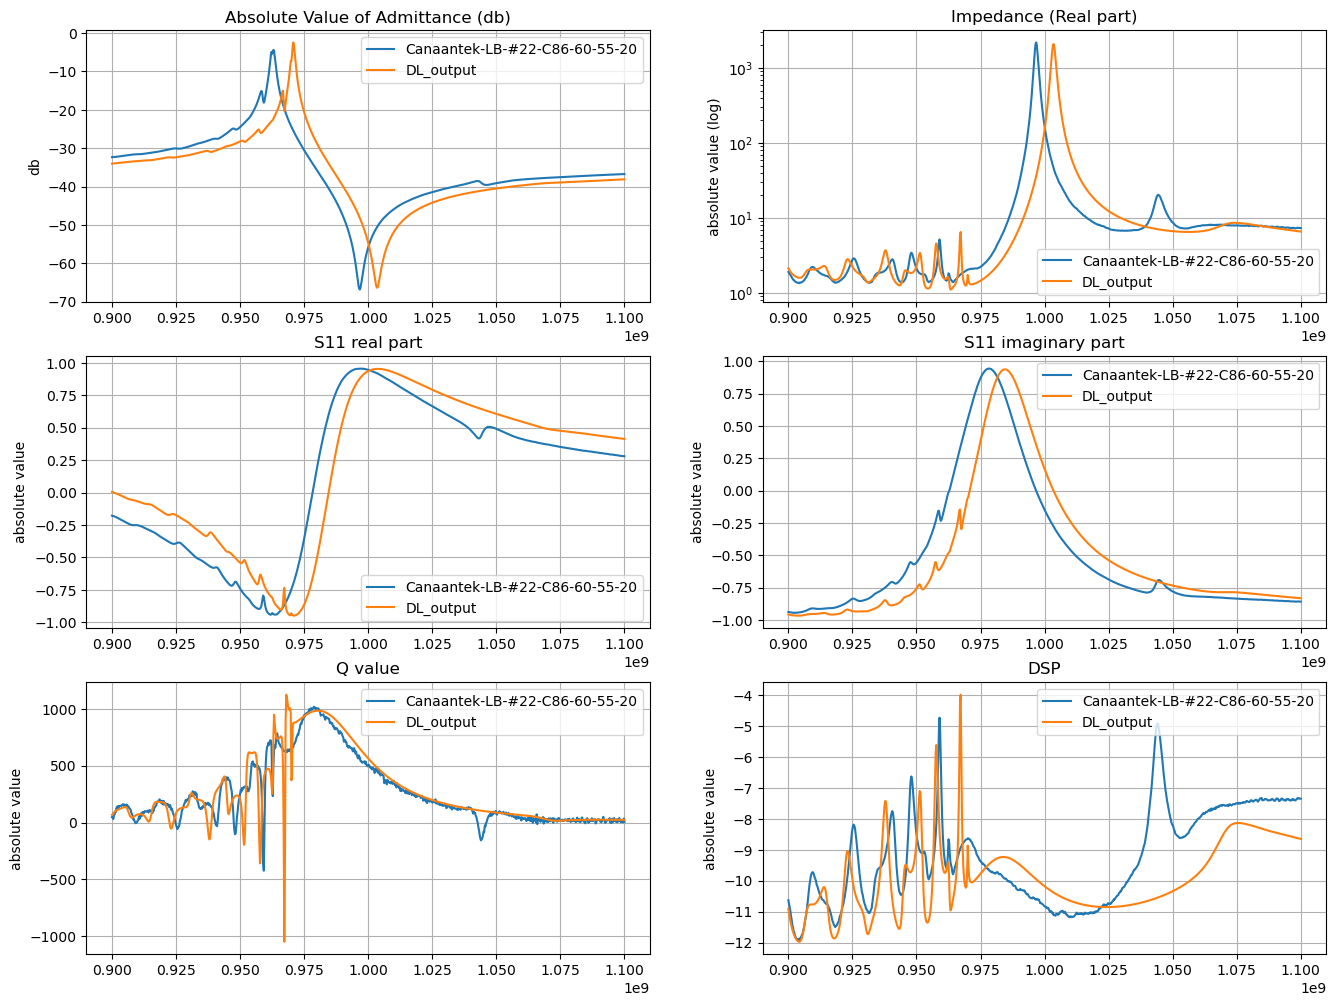

In [132]:
import numpy as np
from data_gene_new import cacul
import skrf as rf
from PackClass import Plot_all
x= np.genfromtxt('./loss_picture/elder/result60-45-200.csv')
MP=55
NT = 60
P = 200
pitch = 20
freq = np.linspace(9*1e8,1.1*1e9,801)
y = cacul(x,freq, NT,P*1E-8)
test_path = 'C:\\Users\\caizhi.zheng\\code\\For AI\\SNP Selection/'+'LT'+str(NT)+ 'MP'+str(MP) +'P'+str(pitch) +'/'
saw_set = rf.read_all_networks(test_path)
for name in saw_set:
    saw = saw_set[name]

y0 = saw['900-1100MHZ'].y[:,0,0]
pp = Plot_all(y0, y, freq, name1 = saw.name, path = '')
pp.plot_all()

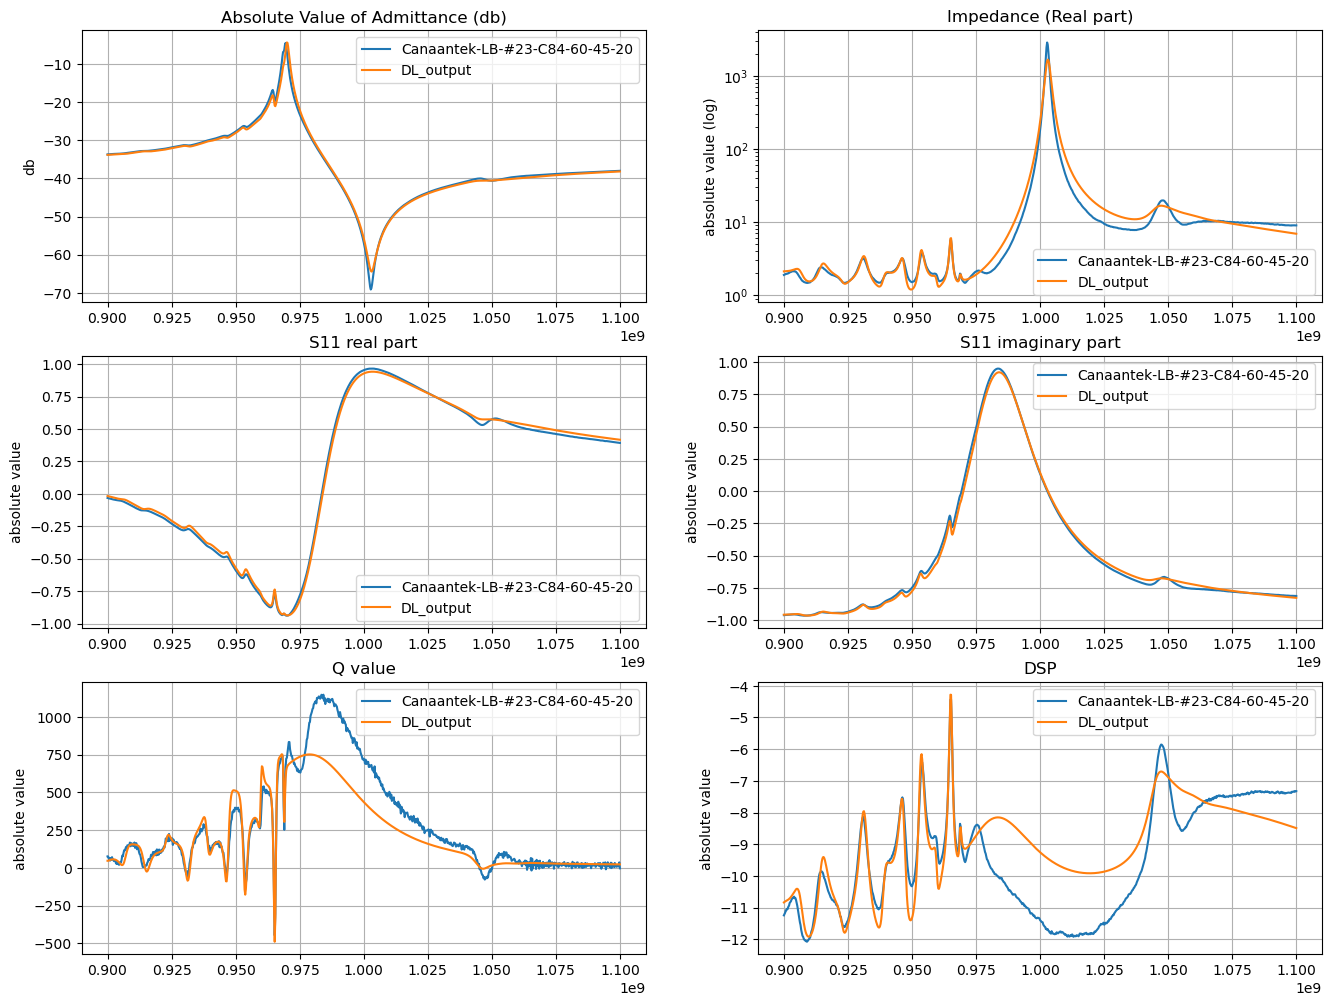

In [7]:
x1 = x
x1[0] = 0.259
x1[3] = 0.116235
x1[4] = 4028.5
y = cacul(x1,freq, NT,P*1E-8)
pp = Plot_all(y0, y, freq, name1 = saw.name, path = '')
pp.plot_all()

In [139]:
import numpy as np
from PackClass import Plot_all
from data_gene_4paras import cacul
N = 142
suffix = str(int(NT)) + '-' + str(int(MP)) + '-' + str(int(P))
R_S = np.genfromtxt('D:/data/Data_2paras/out/MP55.csv',delimiter=',')[N]
freq = np.linspace(9*1e8,1.1*1e9,801)
X = np.genfromtxt('D:/data/Data_4paras/result'+suffix+'.csv',delimiter=',')
y_12 = np.genfromtxt('D:/data/Data_2paras/result'+suffix+'.csv',delimiter=',')
y = cacul(X,y_12,R_S,freq, NT,P*1E-8)

In [140]:
pp = Plot_all(y,y,freq,name1=saw.name,path='')
xyz = pp.YtoZS(y,freq)

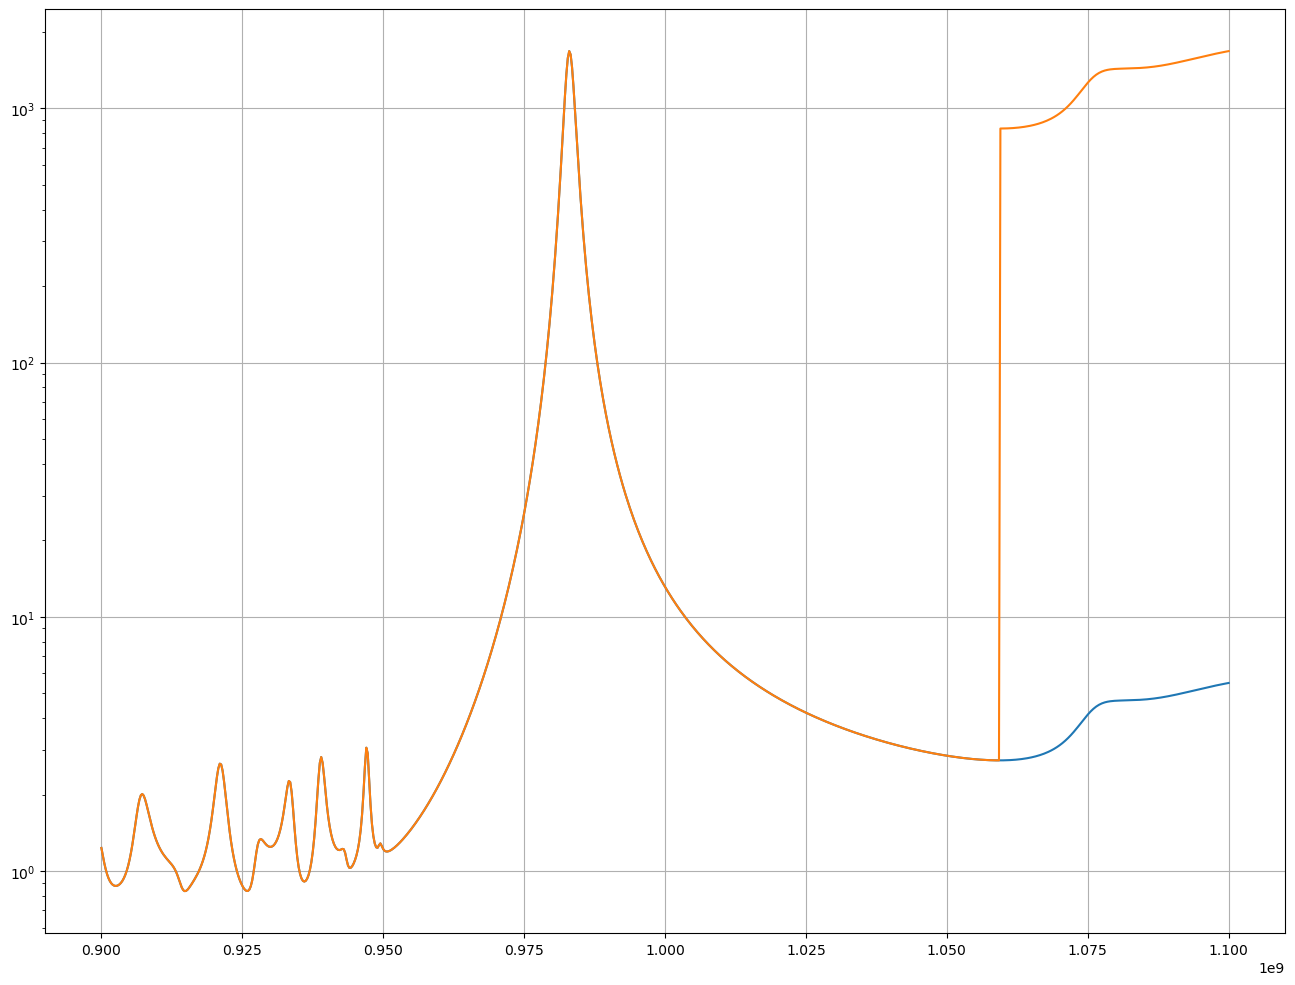

In [151]:
import matplotlib.pyplot as plt 
plt.figure(figsize=[16, 12])
plt.plot(freq,xyz[1])
plt.plot(freq,imped)
# plt.plot(freq[argma],xyz[1][argma],'o')
# plt.plot(freq[argmi],xyz[1][argmi],'o')
# plt.plot(freq[a_ma],xyz[1][a_ma],'o')
plt.grid('on')
plt.yscale('log')

### 找到所有极值点再排除最值以前的

In [142]:
from scipy.signal import argrelextrema
argmi = argrelextrema(xyz[1],np.less)[0]
argma = argrelextrema(xyz[1],np.greater)[0]

In [143]:
max = y1 = np.argmax(xyz[1])

In [125]:
a_ma = argma[argma > y1][0]
a_mi = argmi[argmi > y1][0]
print(a_ma)
print(a_mi)

539
516


In [150]:
imped = xyz[1].copy()
imped = higherex(imped)
# imped[a_mi+1:2*a_ma - a_mi] = imped[a_mi+1:2*a_ma - a_mi]*(xyz[1][y1]/xyz[1][a_ma])

no extrme point after max


In [75]:
imped.argmax()

456

In [78]:
print(len(argma[argma > y1]) == 1 and len(argmi[argmi > y1]) == 1)

True


In [147]:
np.argwhere(xyz[1]==xyz[1][-1])[0][0]

800

In [149]:
def higherex(x):
    argma = argrelextrema(x, np.greater)[0]
    argmi = argrelextrema(x, np.less)[0]
    max = np.argmax(x)
    if max != argma[-1]:
        a_ma = argma[argma>max][xyz[1][argma[argma>max]].argmax()]
        a_mi = argmi[a_ma > argmi][-1]
    else: 
        a_ma = 800
        a_mi = argmi[a_ma > argmi][-1]
        print('no extrme point after max')
        
    # print(len(argma[argma > max]) == 1 and len(argmi[argmi > max]) == 1)
    x_new = x.copy()
    x_new[a_mi+1:] = x_new[a_mi+1:] * (x[max]/x[a_ma])
    # x_new[a_mi+1:2*a_ma - a_mi] = x_new[a_mi+1:2*a_ma - a_mi] * (x[max]/x[a_ma])
    return x_new

In [87]:
# fre_str = str(fre_0*100) + '-' + str((fre_0+5)*100) +'MHZ'
[Y0_Y11, Y0_Z, Y0_SR, Y0_SI, Y0_Q, Y0_D] = pp.YtoZS(y0, freq)

In [101]:
argma = argrelextrema(YZ, np.greater)[0]
argmi = argrelextrema(YZ, np.less)[0]


In [130]:
# max = np.argmax(YZ)
a_ma = argma[argma>max][YZ[argma[argma>max]].argmax()]
a_mi = argmi[a_ma > argmi ][-1]
print(a_ma)
print(a_mi)

539
516


In [118]:
argmi[a_ma > argmi ][-1]

array([  4,   6,  15,  17,  36,  79,  82,  93,  96, 148, 150, 164, 167,
       200, 233, 243, 272, 283, 314, 317, 507, 515, 529, 532, 537, 541,
       545, 547, 550, 558], dtype=int64)

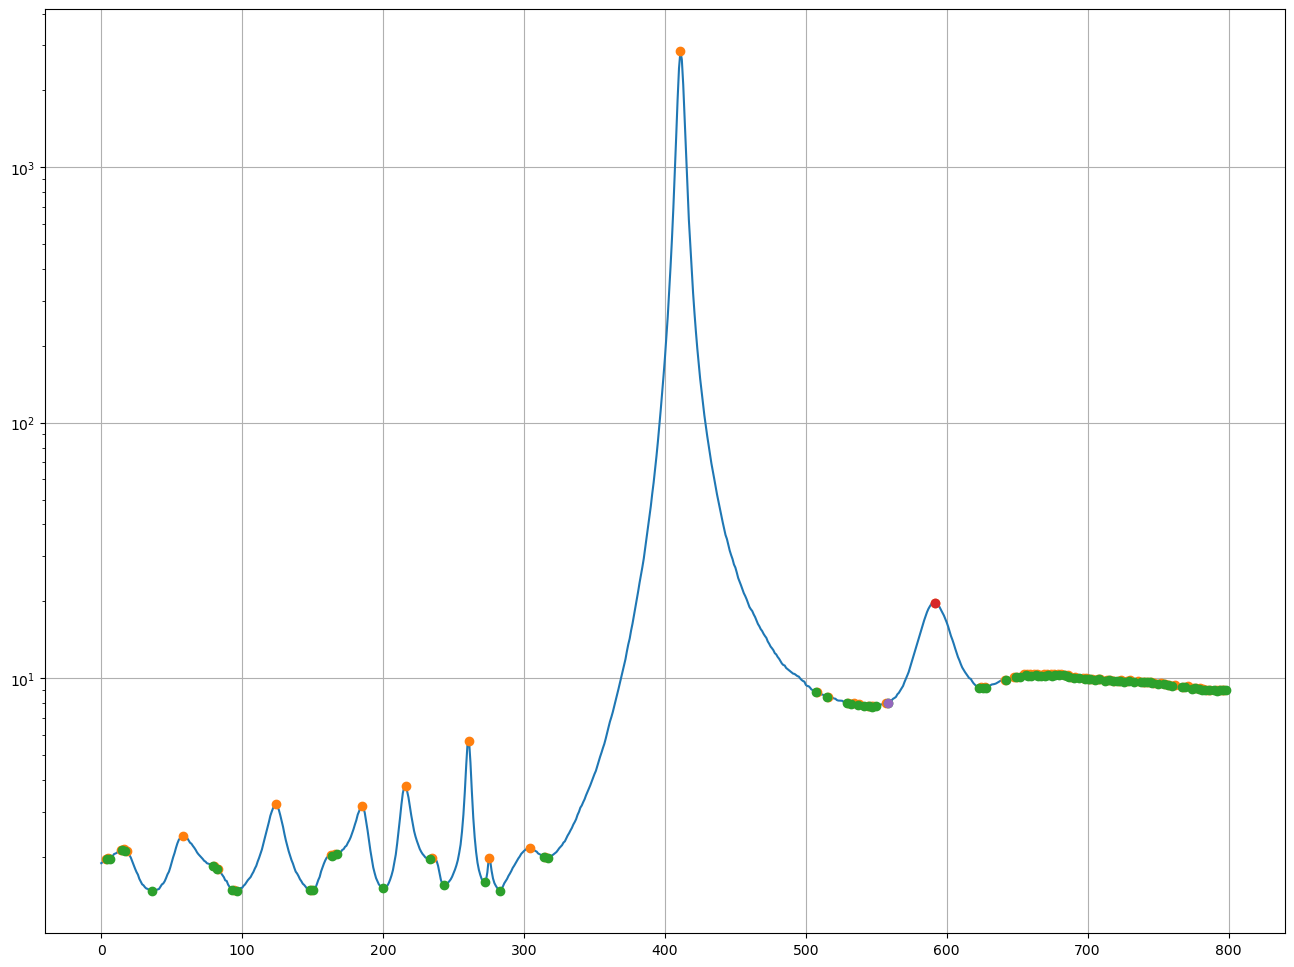

In [120]:
plt.figure(figsize=[16, 12])
# plt.plot(np.arange(801), Y0_Z)
plt.plot(np.arange(801), YZ)
plt.plot(argma, YZ[argma],'o')
plt.plot(argmi, YZ[argmi],'o')
plt.plot(a_ma, YZ[a_ma],'o')
plt.plot(a_mi, YZ[a_mi],'o')
plt.grid('on')
plt.yscale('log')

In [103]:
YZ = Y0_Z.copy()
# YZ = higherex(YZ)


In [1]:
import skrf as rf

In [10]:
rf.read_all_networks('./SNP Selection/LT60MP45P20/')

{'Canaantek-LB-#23-C84-60-45-20': 2-Port Network: 'Canaantek-LB-#23-C84-60-45-20',  0.5-3.0 GHz, 10001 pts, z0=[50.+0.j 50.+0.j]}

Model: "model_13"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_18 (InputLayer)          [(None, 801, 5)]     0           []                               
                                                                                                  
 lambda_15 (Lambda)             [(None, 801, 1),     0           ['input_18[0][0]']               
                                 (None, 801, 1),                                                  
                                 (None, 801, 1),                                                  
                                 (None, 801, 1),                                                  
                                 (None, 801, 1)]                                                  
                                                                                           

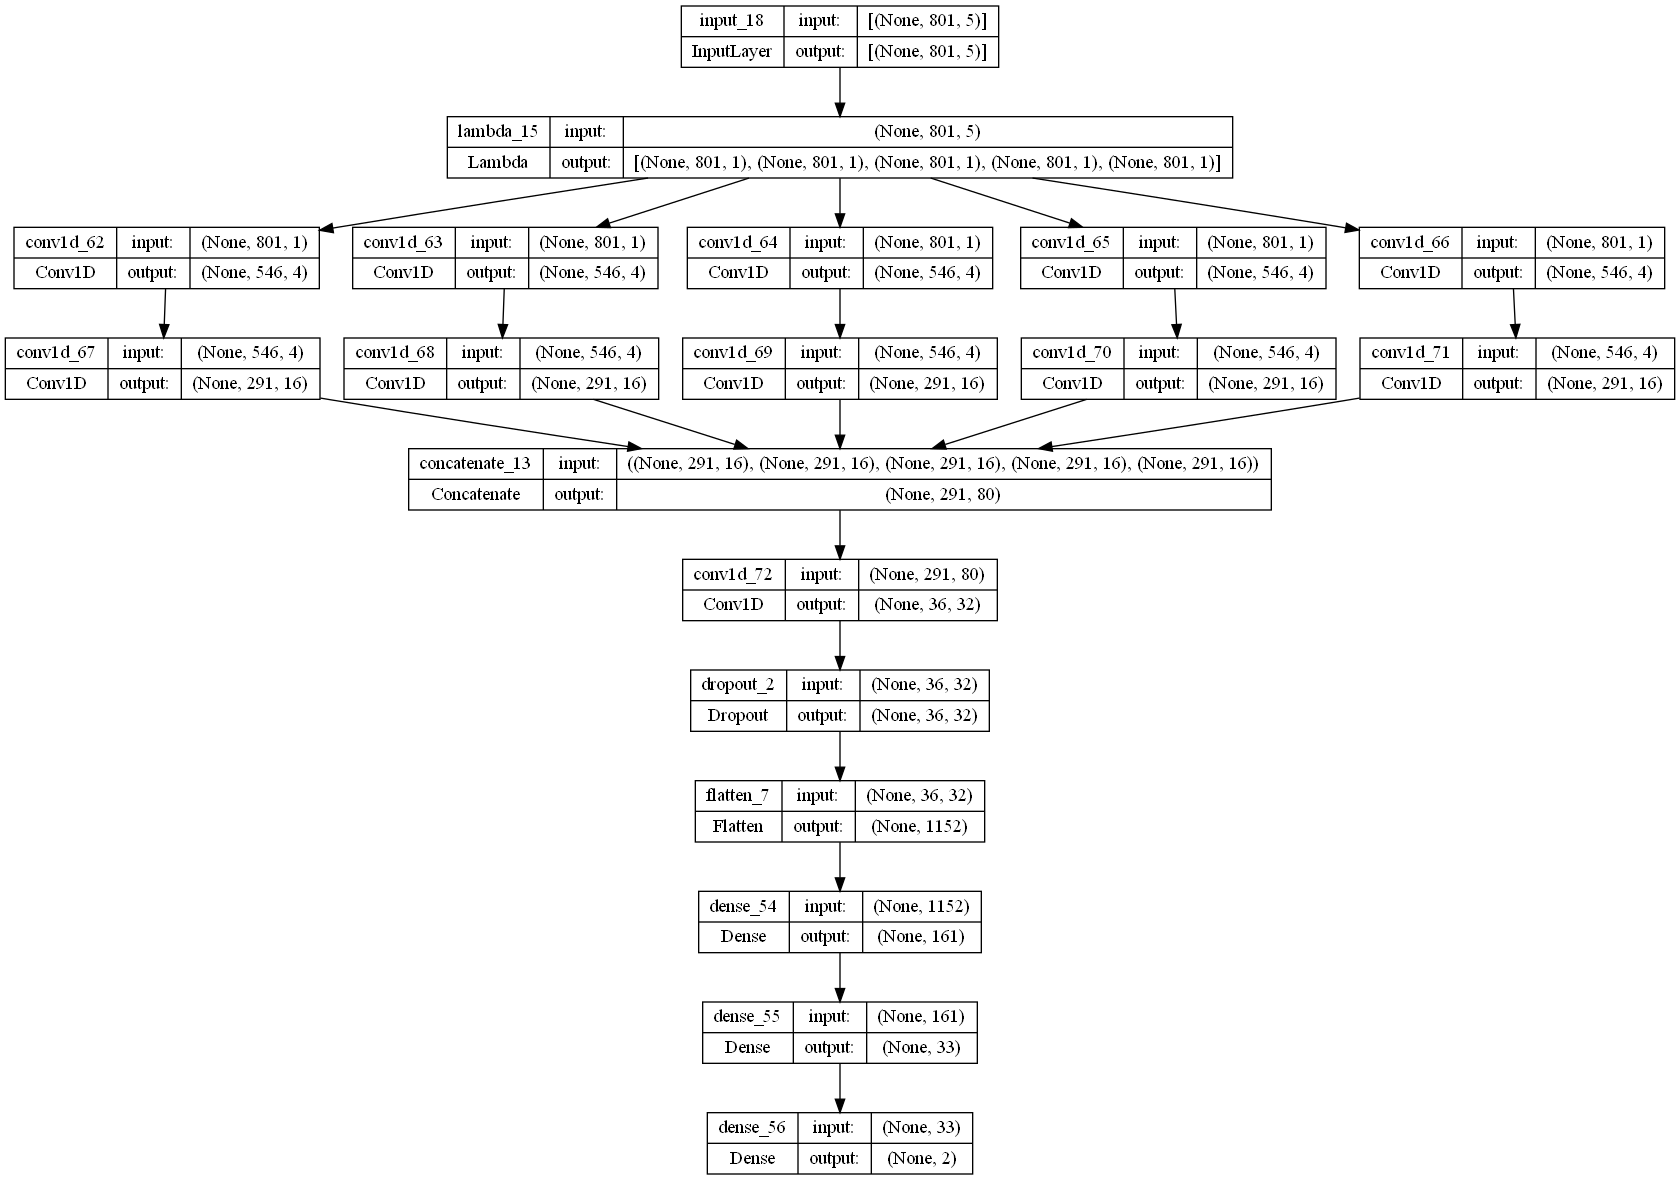

In [18]:
from keras import models, layers, Input
from keras.models import Model
from keras.layers import Lambda, Dense, Concatenate, Conv1D, Flatten, Dropout
import tensorflow as tf
def IANN():
    input = Input(shape=(801,5))
    branchs = Lambda(lambda x: tf.split(x, num_or_size_splits=5, axis=-1))(input)
    # branch1 = Lambda(lambda x:x[:,:,0])(input)  
    # branch2 = Lambda(lambda x:x[:,:,1])(input)
    # branch3 = Lambda(lambda x:x[:,:,2])(input)
    # branch4 = Lambda(lambda x:x[:,:,3])(input)
    # branch5 = Lambda(lambda x:x[:,:,4])(input)
    # hn drop?
    o1 = Conv1D(4,256,activation='relu', kernel_initializer='he_uniform')(branchs[0])
    o2 = Conv1D(4,256,activation='relu', kernel_initializer='he_uniform')(branchs[1])
    o3 = Conv1D(4,256,activation='relu', kernel_initializer='he_uniform')(branchs[2])
    o4 = Conv1D(4,256,activation='relu', kernel_initializer='he_uniform')(branchs[3])
    o5 = Conv1D(4,256,activation='relu', kernel_initializer='he_uniform')(branchs[4])
    o1 = Conv1D(16,256,activation='relu', kernel_initializer='he_uniform')(o1)
    o2 = Conv1D(16,256,activation='relu', kernel_initializer='he_uniform')(o2)
    o3 = Conv1D(16,256,activation='relu', kernel_initializer='he_uniform')(o3)
    o4 = Conv1D(16,256,activation='relu', kernel_initializer='he_uniform')(o4)
    o5 = Conv1D(16,256,activation='relu', kernel_initializer='he_uniform')(o5)
    # o1 = Dense(16,activation='relu', kernel_initializer='he_uniform')(branchs[0])
    # o2 = Dense(16,activation='relu', kernel_initializer='he_uniform')(branchs[1])
    # o3 = Dense(16,activation='relu', kernel_initializer='he_uniform')(branchs[2])
    # o4 = Dense(16,activation='relu', kernel_initializer='he_uniform')(branchs[3])
    # o5 = Dense(16,activation='relu', kernel_initializer='he_uniform')(branchs[4])
    out1 = Concatenate(axis = -1)((o1,o2,o3,o4,o5))
    c1 = Conv1D(32,256,activation='relu', kernel_initializer='he_uniform')(out1)
    c1 = Dropout(0.2)(c1)
    out1 = Flatten()(c1)
    out1 = Dense(161, activation='relu', kernel_initializer='he_uniform')(out1) #model2v6
    h2 = Dense(33, activation='relu', kernel_initializer='he_uniform')(out1)
    out2 = Dense(2,activation='sigmoid', kernel_initializer='he_uniform')(h2)
    model = Model(inputs=input, outputs=out2)
    model.summary() 
    return model
model = IANN()
tf.keras.utils.plot_model(model, show_shapes=True)